Let's build a classifier to see if we can identify player features that lead to clutchness...or if we can predict if a player is clutch or not!

In [3]:
%matplotlib inline
import nba_py as nba
from nba_py import player
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

In [16]:
df = pd.read_csv('overall_df.csv')

In [17]:
df['SC_FG_PCT_DIFF'] = df['FG_PCT'] - df['SC_FG_PCT']
df['SC_FG3_PCT_DIFF'] = df['FG3_PCT'] - df['SC_FG3_PCT']
df['PO_FT_PCT_DIFF'] = df['FT_PCT'] - df['PO_FT_PCT']
df['4Q_FT_PCT_DIFF'] = df['FT_PCT'] - df['4Q_FT_PCT']

In [20]:
df.columns

Index(['Unnamed: 0', 'GROUP_VALUE', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', '4Q_FG_PCT', '4Q_FG3_PCT',
       '4Q_FT_PCT', '4Q_OREB', '4Q_DREB', '4Q_REB', '4Q_AST', '4Q_TOV',
       '4Q_STL', '4Q_BLK', 'PO_FG_PCT', 'PO_FG3_PCT', 'PO_FT_PCT', 'PO_OREB',
       'PO_DREB', 'PO_REB', 'PO_AST', 'PO_TOV', 'PO_STL', 'PO_BLK',
       'SC_FG_PCT', 'SC_FG3_PCT', 'SC_FT_PCT', 'SC_OREB', 'SC_DREB', 'SC_REB',
       'SC_AST', 'SC_TOV', 'SC_STL', 'SC_BLK', 'PERSON_ID',
       'DISPLAY_FIRST_LAST', 'SC_FG_PCT_DIFF', 'SC_FG3_PCT_DIFF',
       'PO_FT_PCT_DIFF', '4Q_FT_PCT_DIFF', 'SEASON_ID'],
      dtype='object')

In [23]:
df2 = df[['SEASON_ID', 'PERSON_ID', 'DISPLAY_FIRST_LAST', 'SC_FG_PCT_DIFF', 'SC_FG3_PCT_DIFF',
       'PO_FT_PCT_DIFF', '4Q_FT_PCT_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK']]

Split up data for training and test set. We are looking to predict 'SC_FG_PCT_DIFF'

In [45]:
def get_reg_season_totals(p_id):
    rt_df1 = player.PlayerCareer(p_id, per_mode = 'PerGame').regular_season_totals()[['PLAYER_ID','SEASON_ID',
                                                                          'PLAYER_AGE','MIN']]
    rt_df1 = rt_df1.groupby(['PLAYER_ID','SEASON_ID']).mean()
    rt_df1 = rt_df1.reset_index()
    rt_df2 = player.PlayerCareer(p_id, per_mode = 'PerGame').regular_season_totals()[['PLAYER_ID','SEASON_ID',
                                                                          'GP','GS','TEAM_ID']]
    rt_df2 = rt_df2[rt_df2['TEAM_ID'] != 0]
    rt_df2 = rt_df2[['PLAYER_ID','SEASON_ID','GP','GS']]
    rt_df2 = rt_df2.groupby(['PLAYER_ID','SEASON_ID']).sum()
    rt_df2 = rt_df2.reset_index()
    
    rt_df = pd.merge(rt_df1, rt_df2, how = 'left', on = ['PLAYER_ID','SEASON_ID'])
    return (rt_df)

In [47]:
plist = player.PlayerList(league_id='00', season='2016-17')
player_ids = plist.info()['PERSON_ID']
main_df = pd.DataFrame()
for cur_player in tqdm(player_ids.values):
    cur_df = get_reg_season_totals(cur_player)
    main_df = main_df.append(cur_df)

100%|██████████| 487/487 [07:16<00:00,  1.05it/s]


In [54]:
main_df.columns = ['PERSON_ID','SEASON_ID','AGE','GP','GS','AVG_MIN']
comb_df = pd.merge(df2,main_df, how = 'left', on = ['PERSON_ID','SEASON_ID'])

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

Let's look at SC FG first

In [160]:
def clutch_to_category(x):
    if x <= 0.05:
        return (1)
    else:
        return (0)

In [192]:
def result_to_category(x):
    if x <= 0.5:
        return (0)
    else:
        return (1)

In [206]:
total_df = comb_df[['SEASON_ID', 'PERSON_ID', 'FG_PCT',
       'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'AGE', 'GP', 'GS', 'AVG_MIN','SC_FG_PCT_DIFF']]
total_df = total_df.dropna()

In [207]:
target = total_df['SC_FG_PCT_DIFF']
target_cat = total_df['SC_FG_PCT_DIFF'].apply(clutch_to_category)
features = total_df[['PERSON_ID', 'FG_PCT',
       'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'AGE', 'GP', 'GS', 'AVG_MIN']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=4)

In [208]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
estimator.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [209]:
df_results = pd.DataFrame()
df_results['prediction'] = estimator.predict(X_test)
df_results['actual'] = y_test.values
df_results['prediction_cat'] = df_results['prediction'].apply(result_to_category)


In [210]:
df_results['abs_error'] = abs(df_results['actual'] - df_results['prediction'])
df_results['pct_error'] = df_results['abs_error']/df_results['actual']

In [211]:
df_results['abs_error'].mean()

0.10540590008928566

In [212]:
df_results['actual'].sum()

41.666333333333306

In [213]:
df_results['prediction'].sum()

44.46870079761907

In [205]:
y_train.apply(clutch_to_category)

1441    0
2480    0
1418    1
2006    0
2502    0
2271    1
858     0
31      0
729     0
915     0
1989    0
511     0
1923    0
211     1
1716    0
2616    0
1746    1
2036    1
1909    0
2325    0
2577    0
2489    1
947     0
2565    0
44      0
2488    0
324     0
740     1
1641    1
1985    0
       ..
974     0
1008    1
588     0
1601    0
814     1
2173    0
2376    1
2739    0
1668    0
155     0
998     0
376     0
1241    1
431     0
2316    1
2603    1
2415    1
2151    1
2158    1
1897    0
296     0
2447    0
941     1
1890    0
1061    0
849     1
1671    1
1031    0
420     0
2599    0
Name: SC_FG_PCT_DIFF, Length: 812, dtype: int64

In [214]:
df_results

,prediction,actual,prediction_cat,abs_error,pct_error
0,0.069710,0.002000,0,0.067710,33.855000
1,0.099947,0.046000,0,0.053947,1.172754
2,0.088771,0.153667,0,0.064896,0.422316
3,0.090937,0.111000,0,0.020063,0.180751
4,0.059960,-0.103000,0,0.162960,-1.582136
5,0.127737,0.288000,0,0.160263,0.556467
6,0.199475,0.258000,0,0.058525,0.226841
7,0.063000,-0.002000,0,0.065000,-32.500000
8,0.072187,0.138000,0,0.065813,0.476908
9,0.143283,0.026000,0,0.117283,4.510897


In [354]:
def to_category_1(x):
    if x <= 0.2:
        return (1)
    else:
        return (0)

def to_category_2(x):
    if x <= 0.095:
        return (1)
    else:
        return (0)

In [355]:
df_results['prediction_cat'] = df_results['prediction'].apply(to_category_2)
df_results['actual_cat'] = df_results['actual'].apply(to_category_1)
df_results['cat_error'] = abs(df_results['actual_cat'] - df_results['prediction_cat'])
df_results['non_abs_cat_error'] = df_results['actual_cat'] - df_results['prediction_cat']

In [356]:
print('abs cat error: ' + str(df_results['cat_error'].mean()))
print('non abs cat error: ' + str(df_results['non_abs_cat_error'].mean()))
print('number of actual clutch correct: ' + str(df_results[df_results['actual_cat'] == 1]['cat_error'].mean()))
print('number of chokers correct: ' + str(df_results[df_results['actual_cat'] == 0]['cat_error'].mean()))
print('number of actual clutch: ' + str(df_results['actual_cat'].sum()))
print('number of predicted clutch: ' + str(df_results['prediction_cat'].sum()))

abs cat error: 0.4325
non abs cat error: -0.2825
number of actual clutch correct: 0.4838709677419355
number of chokers correct: 0.4230769230769231
number of actual clutch: 62
number of predicted clutch: 175


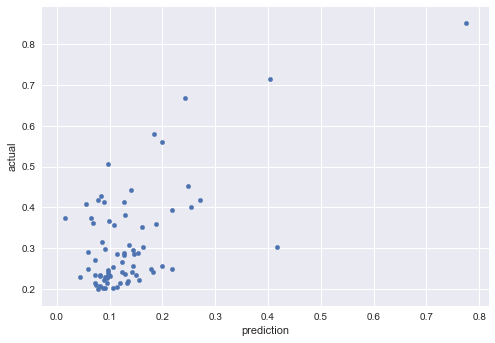

In [302]:
df_results[df_results['actual_cat'] == 0].plot(kind = 'scatter', x = 'prediction', y = 'actual')

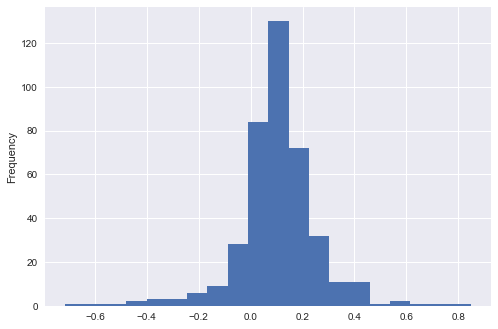

In [294]:
df_results['actual'].plot(kind = 'hist', bins = 20)

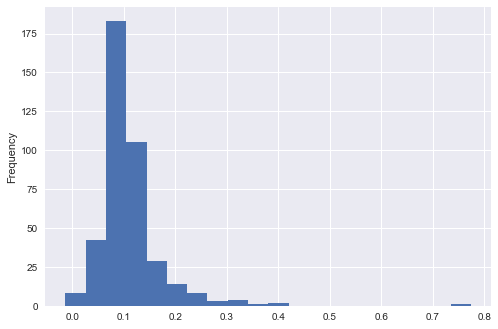

In [293]:
df_results['prediction'].plot(kind = 'hist', bins = 20)

In [357]:
estimator.feature_importances_

array([ 0.06862291,  0.21024855,  0.05147243,  0.06017939,  0.03665899,
        0.02965887,  0.0328561 ,  0.07066484,  0.03911599,  0.03213108,
        0.02793603,  0.04204597,  0.0990404 ,  0.17052788,  0.02884058])

In [358]:
features.columns

Index(['PERSON_ID', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'AGE', 'GP', 'GS', 'AVG_MIN'],
      dtype='object')

In [362]:
plist = player.PlayerList(league_id='00', season='1999-00')
plist.info()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
0,1512,"Anstey, Chris",Chris Anstey,1,1997,1999,chris_anstey,1610612741,Chicago,Bulls,CHI,bulls,Y
1,769,"Armstrong, B.J.",B.J. Armstrong,1,1989,1999,b.j._armstrong,1610612741,Chicago,Bulls,CHI,bulls,Y
2,138,"Avent, Anthony",Anthony Avent,1,1992,1999,anthony_avent,1610612746,Los Angeles,Clippers,LAC,clippers,Y
3,1753,"Bailey, Toby",Toby Bailey,1,1998,2002,toby_bailey,1610612756,Phoenix,Suns,PHX,suns,Y
4,787,"Barkley, Charles",Charles Barkley,1,1984,1999,charles_barkley,1610612745,Houston,Rockets,HOU,rockets,Y
5,1003,"Barry, Drew",Drew Barry,1,1997,1999,drew_barry,1610612737,Atlanta,Hawks,ATL,hawks,Y
6,104,"Benjamin, Benoit",Benoit Benjamin,0,1985,1999,benoit_benjamin,0,,,,,Y
7,712,"Bennett, Mario",Mario Bennett,0,1995,2002,mario_bennett,0,,,,,Y
8,177,"Bogues, Muggsy",Muggsy Bogues,1,1987,2000,muggsy_bogues,1610612761,Toronto,Raptors,TOR,raptors,Y
9,1564,"Bohannon, Etdrick",Etdrick Bohannon,1,1997,2000,etdrick_bohannon,1610612746,Los Angeles,Clippers,LAC,clippers,Y


In [363]:
def get_player_data(pl_id):
    #Takes in player id and returns dataframe with player's historical data under specific conditions
    #We are observing shot percentages, rebounds, assists, turnovers and blocks
    #overall year by year data
    p_df1 = player.PlayerYearOverYearSplits(pl_id, period = '0').by_year()
    p_df1 = p_df1[['GROUP_VALUE','FG_PCT','FG3_PCT', 'FT_PCT', 'OREB', 'DREB',
                           'REB', 'AST', 'TOV', 'STL', 'BLK']]
    if p_df1.empty == False:
        p_df1 = p_df1.groupby(['GROUP_VALUE']).mean()
        p_df1 = p_df1.reset_index()
    
    p_df2 = player.PlayerYearOverYearSplits(pl_id, period = '4').by_year()
    p_df2 = p_df2[['GROUP_VALUE','FG_PCT','FG3_PCT', 'FT_PCT', 'OREB', 'DREB',
                           'REB', 'AST', 'TOV', 'STL', 'BLK']]
    if p_df2.empty == False:
        p_df2 = p_df2.groupby(['GROUP_VALUE']).mean()
        p_df2 = p_df2.reset_index()
    p_df2.columns = ['GROUP_VALUE','4Q_FG_PCT','4Q_FG3_PCT', '4Q_FT_PCT', '4Q_OREB', '4Q_DREB',
                        '4Q_REB', '4Q_AST', '4Q_TOV', '4Q_STL', '4Q_BLK']

    p_main = pd.merge(p_df1,p_df2, how = 'left', on ='GROUP_VALUE')

    p_df3 = player.PlayerYearOverYearSplits(pl_id, season_type = 'Playoffs').by_year()
    p_df3 = p_df3[['GROUP_VALUE','FG_PCT','FG3_PCT', 'FT_PCT', 'OREB', 'DREB',
                        'REB', 'AST', 'TOV', 'STL', 'BLK']]
    if p_df3.empty == False:
        p_df3 = p_df3.groupby(['GROUP_VALUE']).mean()
        p_df3 = p_df3.reset_index()
    p_df3.columns = ['GROUP_VALUE','PO_FG_PCT','PO_FG3_PCT', 'PO_FT_PCT', 'PO_OREB', 'PO_DREB',
                        'PO_REB', 'PO_AST', 'PO_TOV', 'PO_STL', 'PO_BLK']

    p_main = pd.merge(p_main, p_df3, how='left', on = 'GROUP_VALUE')
    
    p_df4 = player.PlayerYearOverYearSplits(pl_id, shot_clock_range = '4-0 Very Late').by_year()
    p_df4 = p_df4[['GROUP_VALUE','FG_PCT','FG3_PCT', 'FT_PCT', 'OREB', 'DREB',
                        'REB', 'AST', 'TOV', 'STL', 'BLK']]
    if p_df4.empty == False:
        p_df4 = p_df4.groupby(['GROUP_VALUE']).mean()
        p_df4 = p_df4.reset_index()
    p_df4.columns = ['GROUP_VALUE','SC_FG_PCT','SC_FG3_PCT', 'SC_FT_PCT', 'SC_OREB', 'SC_DREB',
                        'SC_REB', 'SC_AST', 'SC_TOV', 'SC_STL', 'SC_BLK']

    p_main = pd.merge(p_main, p_df4, how='left', on = 'GROUP_VALUE')
    p_main['PERSON_ID'] = [pl_id]*len(p_main)
    
    return (p_main)

In [366]:
get_player_data(2666666)

,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,...,SC_FG3_PCT,SC_FT_PCT,SC_OREB,SC_DREB,SC_REB,SC_AST,SC_TOV,SC_STL,SC_BLK,PERSON_ID
